# 1. Import Data

In [1]:
filepath = "network-traffic-volume-2019-07-01.csv"

In [2]:
import torch
import torch.nn as nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv(filepath, delimiter = ";")

In [4]:
df.head()

,itemid,clock,num,value_min,value_avg,value_max
0,159138,1563192000,60,170651112,222446310,245355432
1,159138,1563188400,60,92258968,156333926,245517360
2,159138,1563184800,60,29854256,73581269,121096792
3,159138,1563181200,60,333720,12801917,43525128
4,159138,1563177600,60,183976,1146488,11797152


# 2. Data Preprocessing

## 2-1. change time using datatime

In [5]:
import datetime
df["clock"] = df["clock"].apply(lambda x: datetime.datetime.fromtimestamp(x).strftime('%Y/%m/%d %H:%M:%S'))

In [6]:
df.head(30) #데이터가 1시간 단위로 저장 (num -> 60 => 60min단위?)

,itemid,clock,num,value_min,value_avg,value_max
0,159138,2019/07/15 21:00:00,60,170651112,222446310,245355432
1,159138,2019/07/15 20:00:00,60,92258968,156333926,245517360
2,159138,2019/07/15 19:00:00,60,29854256,73581269,121096792
3,159138,2019/07/15 18:00:00,60,333720,12801917,43525128
4,159138,2019/07/15 17:00:00,60,183976,1146488,11797152
5,159138,2019/07/15 16:00:00,60,147520,1271715,10617720
6,159138,2019/07/15 15:00:00,60,172960,925170,3531528
7,159138,2019/07/15 14:00:00,60,147920,992344,7077544
8,159138,2019/07/15 13:00:00,60,184448,1235100,3698824
9,159138,2019/07/15 12:00:00,60,368520,1975065,6291176


In [7]:
len(df) / 24 / 30 #6달 정도의 데이터

5.998611111111112

## 2-2. sorting data

In [8]:
df = df.sort_values("clock")

In [9]:
df.head()

,itemid,clock,num,value_min,value_avg,value_max
4318,159138,2019/01/16 23:00:00,60,176234272,218584709,282860160
4317,159138,2019/01/17 00:00:00,60,175043128,239018429,302135312
4316,159138,2019/01/17 01:00:00,60,192060848,247729961,455722696
4315,159138,2019/01/17 02:00:00,60,185162976,222326142,268226440
4314,159138,2019/01/17 03:00:00,60,169504880,220546435,306695032


## 2-3. data visualization

In [10]:
dates = pd.DatetimeIndex(df['clock'])
ndf = df.set_index(dates).asfreq('60T')
ndf['value_avg'] = ndf['value_avg'] / 1000  # Plot in Mbps
test_length = int(ndf.shape[0] * 0.3)
train_length = ndf.shape[0] - test_length
ndf.index[train_length:][0]

Timestamp('2019-05-22 23:00:00', freq='60T')

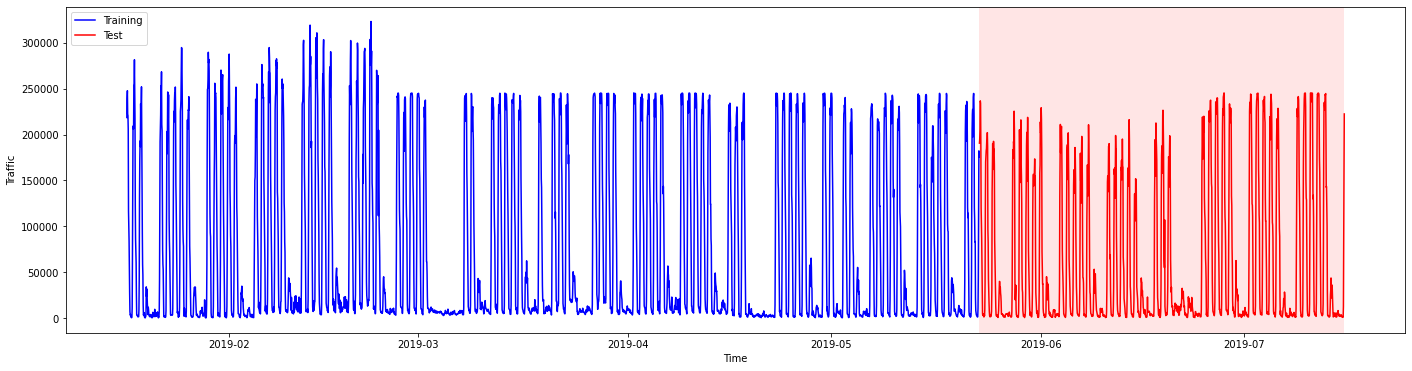

In [11]:
plt.figure(figsize=[24, 6])
plt.plot(ndf.index[:train_length], ndf['value_avg'][:train_length], label='Training', color='blue')
plt.plot(ndf.index[train_length:], ndf['value_avg'][train_length:], label='Test', color='red')
plt.axvspan(ndf.index[train_length:][0], ndf.index[train_length:][-1],  facecolor='r', alpha=0.1)

plt.xlabel('Time')
plt.ylabel('Traffic')
plt.legend(loc='best')
plt.show()

##2.4 data windowing

In [12]:
def create_sequences(data, seq_length):
  xs = []
  ys = []
  for i in range(len(data)-seq_length):
      x = data.iloc[i:(i+seq_length)]
      y = data.iloc[i+seq_length]
      xs.append(x)
      ys.append(y)
  return np.array(xs), np.array(ys)

In [13]:
sequence_len = 3
X, y = create_sequences(df["value_avg"], sequence_len)

In [14]:
X[:10]

array([[218584709, 239018429, 247729961],
       [239018429, 247729961, 222326142],
       [247729961, 222326142, 220546435],
       [222326142, 220546435, 205955438],
       [220546435, 205955438, 116497843],
       [205955438, 116497843,  98591947],
       [116497843,  98591947,  84352362],
       [ 98591947,  84352362,  54736467],
       [ 84352362,  54736467,  28047113],
       [ 54736467,  28047113,   7274809]])

## 2.5 data splitting

In [15]:
train_size = int(df.shape[0] * 0.7)
val_size = int(df.shape[0] * 0.9) #기준점

X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:val_size], y[train_size:val_size]
X_test, y_test = X[val_size:], y[val_size:]

In [16]:
print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(3023, 3) (864, 3) (429, 3)
(3023,) (864,) (429,)


## 2.6 data scaling

In [17]:
'''sc = StandardScaler()

X_train = sc.fit_transform(X_train)
X_val = sc.transform(X_val)
X_test = sc.transform(X_test)'''

def MinMaxScale(array, min, max):
    return (array - min) / (max - min)

MIN = X_train.min()
MAX = X_train.max()

#MinMax 스케일링
X_train = MinMaxScale(X_train, MIN, MAX)
y_train = MinMaxScale(y_train, MIN, MAX)
X_val = MinMaxScale(X_val, MIN, MAX)
y_val = MinMaxScale(y_val, MIN, MAX)
X_test = MinMaxScale(X_test, MIN, MAX)
y_test = MinMaxScale(y_test, MIN, MAX)

## 2.7 data to tensor

In [18]:
def to_Tensor(array) :
  return torch.from_numpy(array).float()

In [19]:
X_train = to_Tensor(X_train)
y_train = to_Tensor(y_train)
X_val = to_Tensor(X_val)
y_val = to_Tensor(y_val)
X_test = to_Tensor(X_test)
y_test = to_Tensor(y_test)

# 3. Training

In [20]:
class LSTM(nn.Module):
  def __init__(self, n_features, n_hidden, seq_len, n_layers, dropout=0.2):
      super(LSTM, self).__init__()
      self.n_hidden = n_hidden
      self.seq_len = seq_len
      self.n_layers = n_layers
      self.lstm = nn.LSTM(
          input_size=n_features,
          hidden_size=n_hidden,
          num_layers=n_layers,
          dropout = dropout
      )
      self.linear = nn.Linear(in_features=n_hidden, out_features=1)
  def reset_hidden_state(self):
      self.hidden = (
          torch.zeros(self.n_layers, self.seq_len, self.n_hidden),
          torch.zeros(self.n_layers, self.seq_len, self.n_hidden)
      )
  def forward(self, sequences):
      lstm_out, self.hidden = self.lstm(
          sequences.view(len(sequences), self.seq_len, -1),
          self.hidden
      )
      last_time_step = lstm_out.view(self.seq_len, len(sequences), self.n_hidden)[-1]
      y_pred = self.linear(last_time_step)
      return y_pred

In [21]:
def train_model(model, train_data, train_labels, val_data=None, val_labels=None, num_epochs=20, verbose = 10, patience = 10, learning_rate=0.001):
    loss_fn = torch.nn.L1Loss()
    optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate)
    train_hist = []
    val_hist = []
    for t in range(num_epochs):
        epoch_loss = 0

        for idx, seq in enumerate(train_data):

            model.reset_hidden_state() # seq 별 hidden state reset

            # train loss
            seq = torch.unsqueeze(seq, 0)
            y_pred = model(seq)
            loss = loss_fn(y_pred[0].float(), train_labels[idx]) # 1개의 step에 대한 loss

            # update weights
            optimiser.zero_grad()
            loss.backward()
            optimiser.step()

            epoch_loss += loss.item()

        train_hist.append(epoch_loss / len(train_data))

        if val_data is not None:

            with torch.no_grad():

                val_loss = 0

                for val_idx, val_seq in enumerate(val_data):

                    model.reset_hidden_state() # seq 별로 hidden state 초기화

                    val_seq = torch.unsqueeze(val_seq, 0)
                    y_val_pred = model(val_seq)
                    val_step_loss = loss_fn(y_val_pred[0].float(), val_labels[val_idx])

                    val_loss += val_step_loss

            val_hist.append(val_loss / len(val_data)) # val hist에 추가

            ## verbose 번째 마다 loss 출력
            if t % verbose == 0:
                print(f'Epoch {t} train loss: {epoch_loss / len(train_data)} val loss: {val_loss / len(val_data)}')

            ## patience 번째 마다 early stopping 여부 확인
            if (t % patience == 0) & (t != 0):

                ## loss가 커졌다면 early stop
                if val_hist[t - patience] < val_hist[t] :

                    print('\n Early Stopping')

                    break

        elif t % verbose == 0:
            print(f'Epoch {t} train loss: {epoch_loss / len(train_data)}')


    return model, train_hist, val_hist

In [22]:
model = LSTM(
    n_features=1,
    n_hidden=50,
    seq_len=sequence_len,
    n_layers=1,
    dropout=0.2
)
model, train_hist, val_hist = train_model(
    model,
    X_train,
    y_train,
    X_val,
    y_val,
    num_epochs=20,
    verbose=1,
    patience=5,
    learning_rate=0.0001
)

Epoch 0 train loss: 0.16680217977991224 val loss: 0.06449215859174728
Epoch 1 train loss: 0.05160118353365881 val loss: 0.04398668557405472
Epoch 2 train loss: 0.04854023441668243 val loss: 0.04401395469903946
Epoch 3 train loss: 0.0484854358265665 val loss: 0.043946657329797745
Epoch 4 train loss: 0.04844517684267453 val loss: 0.04392271116375923
Epoch 5 train loss: 0.048423251565116794 val loss: 0.04389122501015663
Epoch 6 train loss: 0.04838565475622377 val loss: 0.04388881102204323
Epoch 7 train loss: 0.04833767230648965 val loss: 0.04387710615992546
Epoch 8 train loss: 0.04832974470286666 val loss: 0.04384575039148331
Epoch 9 train loss: 0.04828255548771687 val loss: 0.043849971145391464
Epoch 10 train loss: 0.04827146386240772 val loss: 0.043842557817697525
Epoch 11 train loss: 0.048235753317312884 val loss: 0.043824341148138046
Epoch 12 train loss: 0.04821303410926868 val loss: 0.04383213818073273
Epoch 13 train loss: 0.04818847603768833 val loss: 0.043849531561136246
Epoch 14 t

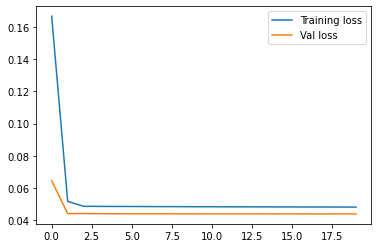

In [23]:
plt.plot(train_hist, label="Training loss")
plt.plot(val_hist, label="Val loss")
plt.legend()

# 4. Prediction

## 4-1. One-step prediction

In [24]:
pred_dataset = X_test

with torch.no_grad():
    preds = []
    for _ in range(len(pred_dataset)):
        model.reset_hidden_state()
        y_test_pred = model(torch.unsqueeze(pred_dataset[_], 0))
        pred = torch.flatten(y_test_pred).item()
        preds.append(pred)

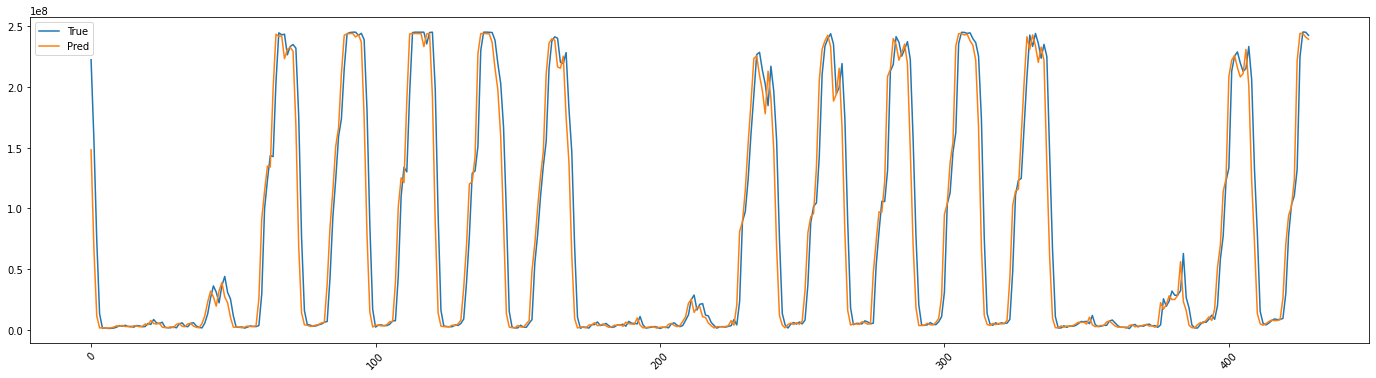

In [25]:
plt.figure(figsize=(24,6))
plt.plot(df.index[-len(y_test):], np.array(y_test) * (MAX-MIN) + MIN, label='True')
plt.plot(df.index[-len(preds):], np.array(preds) * (MAX-MIN) + MIN, label='Pred')
plt.xticks(rotation=45)
plt.legend()

In [26]:
from sklearn.metrics import mean_squared_error
MSE = mean_squared_error(y_test, preds)
RMSE = np.sqrt(MSE)
NRMSE = RMSE / (max(y_test).item()-min(y_test).item())
print("NRMSE :", NRMSE)

NRMSE : 0.11345033812091297


## 4-2. Multi-step prediction

In [27]:
with torch.no_grad():
    test_seq = X_test[:1] # 첫번째 테스트 셋, 3차원
    preds = []
    for _ in range(len(X_test)):
        model.reset_hidden_state()
        y_test_pred = model(test_seq)
        pred = torch.flatten(y_test_pred).item()
        preds.append(pred)
        new_seq = test_seq.numpy().flatten()
        new_seq = np.append(new_seq, [pred]) # 시퀀스에 추가
        new_seq = new_seq[1:] # 추가된 값을 포함하여 seq_length 맞추기
        test_seq = torch.as_tensor(new_seq).view(1, sequence_len, 1).float()

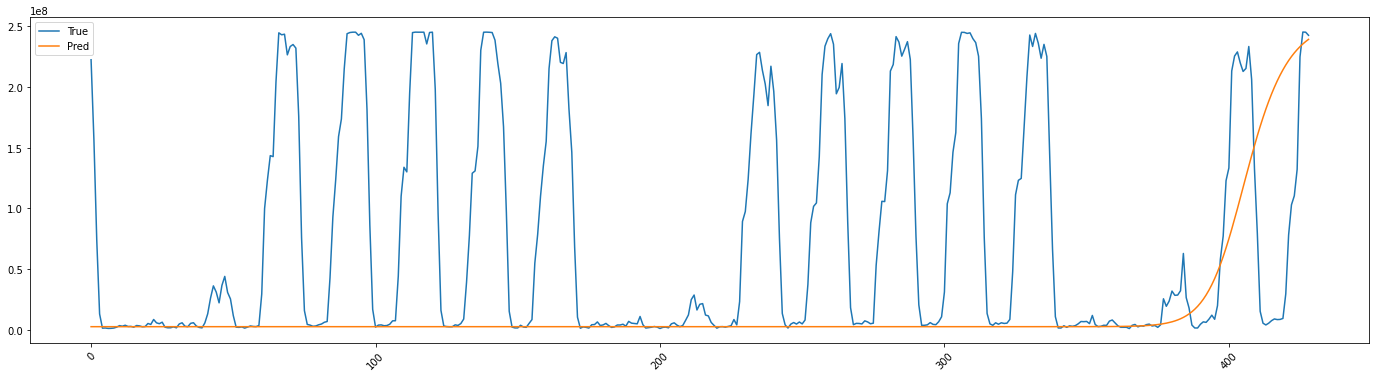

In [28]:
plt.figure(figsize=(24,6))
plt.plot(df.index[-len(y_test):], np.array(y_test) * (MAX-MIN) + MIN, label='True')
plt.plot(df.index[-len(preds):], np.array(preds)  * (MAX-MIN) + MIN, label='Pred')
plt.xticks(rotation=45)
plt.legend()

In [29]:
MSE = mean_squared_error(y_test, preds)
RMSE = np.sqrt(MSE)
NRMSE = RMSE / (max(y_test).item()-min(y_test).item())
print("NRMSE :", NRMSE)

NRMSE : 0.4743105709816904
